In [19]:
!pip install torch torchvision opencv-python pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 157.6 MB/s eta 0:00:0000:0100:01


In [1]:
!pip install tensorflow

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import re
import statistics as stats  
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.optim as optim

import time
import torch.nn as nn
from torchvision import models
from torch.cuda.amp import autocast, GradScaler
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from torchvision.models import efficientnet_b0


2024-09-29 00:20:43.496495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 00:20:43.512902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 00:20:43.532515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 00:20:43.538544: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 00:20:43.552610: I tensorflow/core/platform/cpu_feature_guar

## Data Loading/ Data Preprocessing

In [3]:
train_data = "archive (4)/train"
test_data = "archive (4)/test"

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),  # Horizontal flip
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        AddGaussianNoise(0., 0.1)  # Adding Gaussian Noise with 0 mean and 0.1 std
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
train_dataset = datasets.ImageFolder(train_data, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_data, transform=data_transforms['test'])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Classes

In [8]:
def plot_images_from_classes(dataset, class_names):
    plt.figure(figsize=(14, 10))
    
    for i in range(len(class_names)):
        # Encontrar o primeiro índice de cada classe
        class_idx = next(idx for idx, target in enumerate(dataset.targets) if target == i)
        
        # Carregar a imagem correspondente e remover normalização para exibir
        image, label = dataset[class_idx]
        image = image.permute(1, 2, 0).numpy()  # Alterar a ordem dos canais
        
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = std * image + mean  # Reverter normalização
        image = torch.clamp(image, 0, 1)  # Garantir que os valores estão entre 0 e 1
        
        # Subplot para a imagem
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(class_names[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
class_names = train_dataset.classes


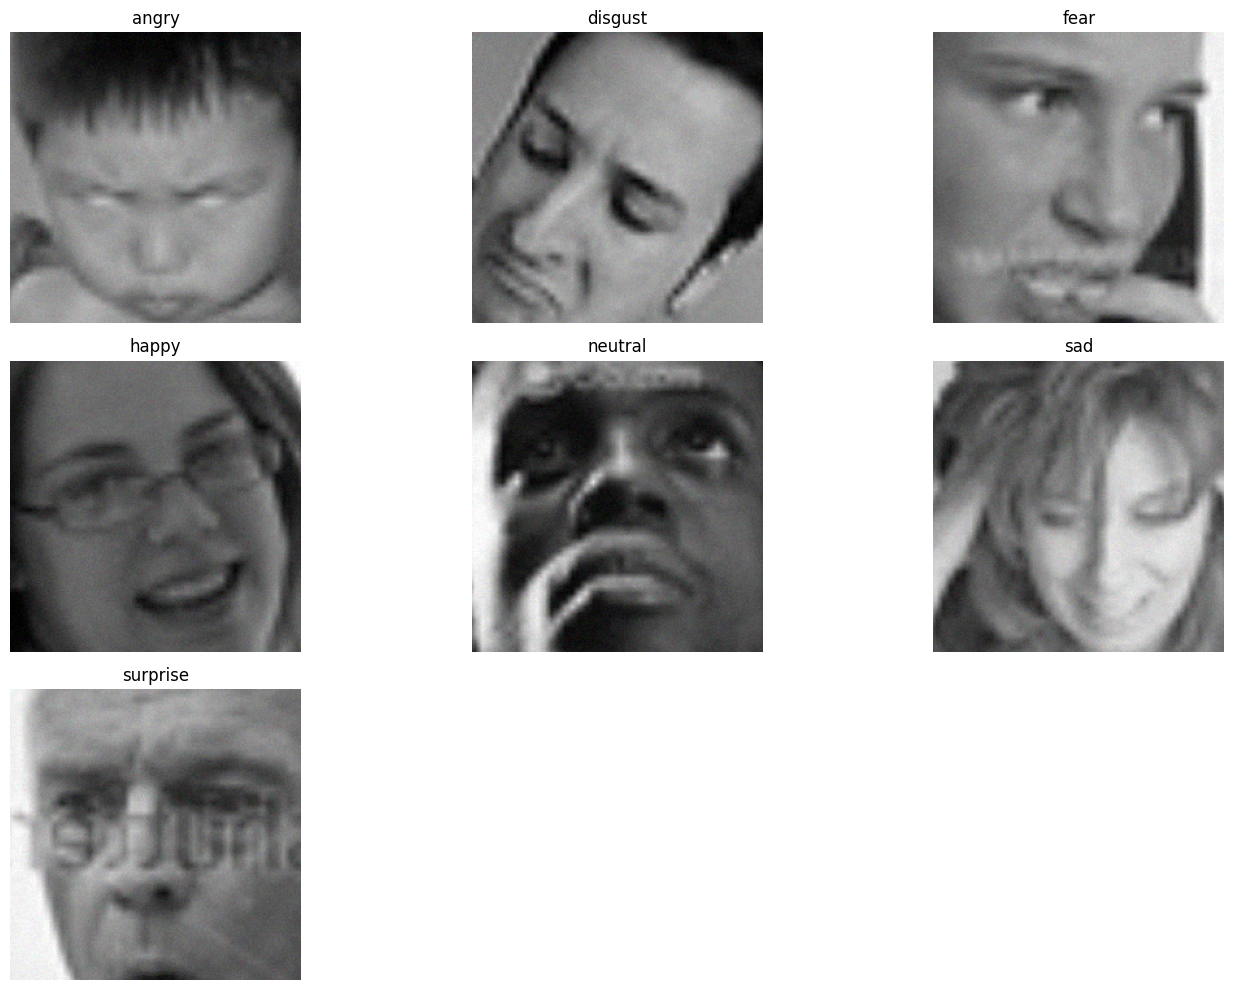

In [10]:
plot_images_from_classes(train_dataset, class_names)


## Modeling

In [11]:
def initialize_model(num_classes):
    # Carregar uma ResNet50 pré-treinada
    model = models.resnet50(pretrained=True)
    
    # Alterar a última camada FC para o número de classes do dataset de emoções
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

In [12]:
num_classes = 7
model = initialize_model(num_classes)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train_step(model, data_loader, criterion, optimizer, scaler, device):
    model.train()  # Coloca o modelo em modo de treinamento
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zera os gradientes

        # Forward pass com autocast para mixed precision
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass e otimização com mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Cálculo de estatísticas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [14]:
def test_step(model, data_loader, criterion, device):
    model.eval()  # Coloca o modelo em modo de avaliação
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Desativa cálculo de gradientes
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [15]:
def workflow(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision training
    best_acc = 0.0  # To keep track of the best accuracy
    best_model_wts = model.state_dict()  # Initialize with the model's current weights
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, scaler, device)
        test_loss, test_acc = test_step(model, test_loader, criterion, device)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        
        # Check if this is the best model so far based on accuracy
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()  # Update the best weights

    # Save the best model weights after training is complete
    model.load_state_dict(best_model_wts)  # Load best weights into the model
    torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    
    print(f'Best model saved with accuracy: {best_acc:.4f}')


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))


In [17]:
num_epochs = 10

In [18]:
workflow(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)


Epoch 1/10:
Train Loss: 1.1793, Train Acc: 0.5531
Test Loss: 1.1161, Test Acc: 0.5850
Epoch 2/10:
Train Loss: 1.0073, Train Acc: 0.6237
Test Loss: 1.0291, Test Acc: 0.6092
Epoch 3/10:
Train Loss: 0.9331, Train Acc: 0.6522
Test Loss: 0.9766, Test Acc: 0.6346
Epoch 4/10:
Train Loss: 0.8647, Train Acc: 0.6787
Test Loss: 0.9896, Test Acc: 0.6403
Epoch 5/10:
Train Loss: 0.7921, Train Acc: 0.7059
Test Loss: 0.9570, Test Acc: 0.6499
Epoch 6/10:
Train Loss: 0.7131, Train Acc: 0.7369
Test Loss: 1.0410, Test Acc: 0.6336
Epoch 7/10:
Train Loss: 0.6311, Train Acc: 0.7694
Test Loss: 1.0367, Test Acc: 0.6421
Epoch 8/10:
Train Loss: 0.5374, Train Acc: 0.8035
Test Loss: 1.0216, Test Acc: 0.6530
Epoch 9/10:
Train Loss: 0.4537, Train Acc: 0.8375
Test Loss: 1.0994, Test Acc: 0.6666
Epoch 10/10:
Train Loss: 0.3730, Train Acc: 0.8668
Test Loss: 1.1670, Test Acc: 0.6590
Best model saved with accuracy: 0.6666
